In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#!pip install pyvisgraph
#!pip install geopandas
#!pip install matplotlib

Node eb16048f-962c-44b2-9651-cc3b67bca83b

In [2]:
import numpy as np
import pyvisgraph as vg
import math
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import control as ctrl
import Global as glob
import time
import local_nav as local

In [ ]:
#simulating the main loop
import time

def getting_vis():
    print("vision started")
    time.sleep(0.5)#simulating execution of the function
    actual,angle=([0.00,1.00],45) #fake data
    return (actual, angle)
    
def kalman(actual, angle):
    print("kalman started")
    time.sleep(0.1) #simulating execution of the function
    print("kalman received position {} and angle {}".format(actual,angle))
    pred_pos=[actual[0]+0.1,actual[1]-0.1]
    pred_angle= angle/1,1
    return pred_pos, pred_angle

def astolfi():
    print("astolfi started")
    time.sleep(0.1)
    
def local_detection():
    print("local detection started")
    for i in range(3):
        prox=ctrl.read_prox_sensors(node,client)
        print(prox)
        if (prox[2]>1000):
            print("object detected")
        aw(client.sleep(0.2))
    
def main_loop():
    while True:
        local_detection()
        actual, angle= getting_vis()
        pred_pos, pred_angle = kalman(actual, angle)
        astolfi()
    
    
#main_loop()

In [ ]:
def update_state(state,obstThrL,obstThrH):
    if state == 0: 
        # switch from goal tracking to obst avoidance if obstacle detected
        if (obst[0] > obstThrH):
            state = 1
            print("change state to local")
        elif (obst[2] > obstThrH):
            state = 1
            print("change state to local")
        elif (obst[1] > obstThrH):
            state = 1
            print("change state to local")
    elif state == 1:
        if obst[0] < obstThrL:
            if obst[2] < obstThrL:
                # switch from obst avoidance to goal tracking if obstacle got unseen
                state = 0
                print("change state to global")
    
    return state
    
#Initializing global path planning
p1 = [(1, 0.5), (2, 0.5), (2, 1.5), (1, 1.5)]
p3 = [(3, 3), (4, 3), (4, 4), (3, 4)]
list_obstacles=[p1,p3]
start_point=[0.0,0.0]
end_point=[4.5, 3.5]
margin=0.2
start_angle=0

path = glob.global_pathplanning(start_point,end_point,list_obstacles,margin)
checkpoints=glob.geometric_path_to_vector(path)  #can be accesed via g too
print("Checkpoints",checkpoints)

checkp=1
actual_angle=0  

y = [0,0]          # powers given to motor wheels
state = 0          # States FSM 0=global nav, 1=local nav
obst = [0,0,0]     # measurements from left, middle, right prox sensors

obstThrL = 2500      # low obstacle threshold to switch state 1->0
obstThrL2 = 3000
obstThrH = 4000      # high obstacle threshold to switch state 0->1  

#start_time = time.time()
#seconds = 1

while True:
    
    # get the proximity sensors value and obstacles values
    prox_horizontal = ctrl.read_prox_sensors(node,client)
    obst = [prox_horizontal[0], prox_horizontal[2], prox_horizontal[4]]
    
    # update the state and speed motors values
    state = update_state(state,obstThrL,obstThrH)
    y = ctrl.read_motors_speed(node,client)
                
    #current_time = time.time()
    #elapsed_time = current_time - start_time
    #if elapsed_time > seconds:
        #print("Finished iterating in: " + str(int(elapsed_time))  + " seconds")
        #break
                
    print("state", state)

    if state == 0:
        """
        # With positon estimation when vision and/or kalman ready
        
        actual,angle = getting_vis()
        pred_pos,pred_angle = kalman(actual, angle)
        
        actual_pos=pred_pos
        actual_angle=pred_angle
        
        if actual_pos == checkpoints[checkp]: # other option: if (actual_pos - checkpoints[checkp]) < error
            checkp=checkp+1
        goal_pos=checkpoints[checkp]
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        
        """
        actual_pos=checkpoints[0]
        goal_pos=checkpoints[1]
        
        """
        # Without estimation, turn and forward method 
        
        #y = ctrl.turn2(goal_pos, actual_pos,actual_angle, node, client)
        #ctrl.set_motors(y[0],y[1],node)
        #y = ctrl.forward2(goal_pos,actual_pos, node, client)
        #actual_angle = ctrl2.angle2points(goal_pos,actual_pos,node) 
        
        """
        
        """
        # Without estimation, astolfi method 
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        print("y astolfi ",y)
        """
        
        """
        # Without estimation, constant velocity
        y = [50,50]
        """
        
        
        # Without estimation without obstacle avoidance: global path in one iteration 
        
        ctrl.globnav(checkpoints,start_angle,node,client)
        
        ctrl.set_motors(y[0],y[1],node)

    elif state == 1:
        print(obst)
        y = local.local_nav(prox_horizontal,y)
        print(y)
        ctrl.set_motors(y[0],y[1],node)

ctrl.stopmotors(node)

In [ ]:
ctrl.stopmotors(node)

In [8]:
#Initializing global path planning
p1 = [(1, 0.5), (2, 0.5), (2, 1.5), (1, 1.5)]
p3 = [(3, 3), (4, 3), (4, 4), (3, 4)]
list_obstacles=[p1,p3]
start_point=[0.0,0.0]
end_point=[4.5, 3.5]
margin=0.2
start_angle=0

#path = glob.global_pathplanning(start_point,end_point,list_obstacles,margin)
#checkpoints=glob.geometric_path_to_vector(path)  #can be accesed via g too
#print("Checkpoints",checkpoints)
checkpoints=[(0.0, 0.0), (1, 0)]
actual_angle=45
checkp=0
start_time = time.time()
seconds = 3

while True:
        ctrl.astolfi(checkpoints[checkp],checkpoints[checkp+1], actual_angle, node)
        
        #y = ctrl.astolfi2(checkpoints[checkp+1],checkpoints[checkp], actual_angle, node)
        #ctrl.set_motors(y[0],y[1],node)
        #actual_angle=ctrl.angle2points(checkpoints[i+1],checkpoints[i],node)
        #ctrl.stopmotors(node)
        
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > seconds:
            print("Finished iterating in: " + str(int(elapsed_time))  + " seconds")
            break

ctrl.stopmotors(node)               

117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
117 82
Finished iterating in: 3 seconds


0    POLYGON ((1.00000 0.50000, 2.00000 0.50000, 2....
1    POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4....
dtype: geometry 



100%|██████████| 1/1 [00:00<00:00, 945.09it/s]

0    POLYGON ((0.90000 0.40000, 0.90000 1.60000, 2....
1    POLYGON ((2.90000 2.90000, 2.90000 4.10000, 4....
dtype: geometry 


 Visibility graph input:  [[Point(0.90, 0.40), Point(0.90, 1.60), Point(2.10, 1.60), Point(2.10, 0.40)], [Point(2.90, 2.90), Point(2.90, 4.10), Point(4.10, 4.10), Point(4.10, 2.90)]] 

Shortest path distance: 6.010849437995489 

0    POLYGON ((0.90000 0.40000, 0.90000 1.60000, 2....
1    POLYGON ((2.90000 2.90000, 2.90000 4.10000, 4....
0                              POINT (0.00000 0.00000)
1                              POINT (0.90000 1.60000)
2                              POINT (4.10000 2.90000)
3                              POINT (4.50000 3.50000)
dtype: geometry 

path  0    POINT (0.00000 0.00000)
1    POINT (0.90000 1.60000)
2    POINT (4.10000 2.90000)
3    POINT (4.50000 3.50000)
dtype: geometry
Checkpoints [[0.0, 0.0], [0.9, 1.6], [4.1, 2.9], [4.5, 3.5]]


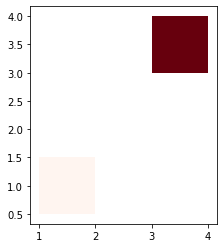

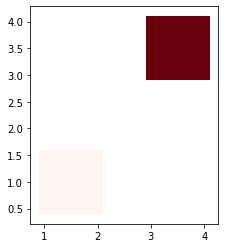

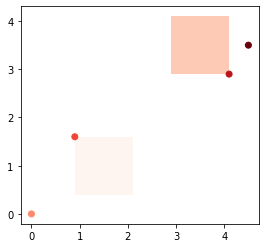

In [9]:
#Initializing global path planning
p1 = [(1, 0.5), (2, 0.5), (2, 1.5), (1, 1.5)]
p3 = [(3, 3), (4, 3), (4, 4), (3, 4)]
list_obstacles=[p1,p3]
start_point=[0.0,0.0]
end_point=[4.5, 3.5]
margin=0.1

g = glob.obstacles_to_polygons(list_obstacles)
glob.plot_geometric_data(g)

g = glob.polygons_add_margin(g,margin)
glob.plot_geometric_data(g)

visgraph = glob.polygons_to_VisibilityGraph(g)

shortest_path = glob.VisibilityGraph_shortest_path(visgraph, start_point, end_point)

distance = glob.path_distance(shortest_path)

path = glob.ShortestPath_to_geometric(shortest_path)
g = g.geometry.append(path.geometry)

#plot_geometric_data(path)
glob.plot_geometric_data(g)
print("path ", path)

checkpoints=glob.geometric_path_to_vector(path)  #can be accesed via g too
print("Checkpoints",checkpoints)